In [7]:
import numpy as np
np.set_printoptions(threshold=np.nan)

import pandas as pd
import sys

sys.path.append('python')
from clusterOutliers import clusterOutliers as coo

In [5]:
def make_sampler(inds=['8462852']): 
    """
    Args:
        inds (Array of strings) - array of indices, as identifying strings, to be pulled from a data frame, 
                                  can be with or without kplr prefix
    Returns:
        Function that will pull the data, indicated by inds, from a dataframe df 
        
    Useful to generate samples across quarters with common sources where data is contained as a 
    Pandas dataframe, with indices set to be identifying labels (i.e. kplr008462852)
    
    To use:
        Define array containing IDs of sources of interest as strings
        Define a sample generator by calling make_sampler(inds=Array of string IDs)
        Generate dataframe by calling new function.

    Example:
    tabby_sample = make_sampler(inds=['8462852'])
    Q4_sample = tabby_sample(Q4.data)
    Q8_sample = tabby_sample(Q8.data)
    etc.
    """
    return lambda df: df[df.index.str.contains('|'.join(inds))]

def import_generator(suffix='_FullSample.csv',
                     filepath="/home/dgiles/Documents/KeplerLCs/output/",
                    fits_files_directory="/home/dgiles/Documents/KeplerLCs/fitsFiles/"):
    """
    Args:
        suffix (str) - the suffix of the file to be imported
        filepath (optional, str) - filepath to the file to be imported
        fits_files_directory (optional, str) - path to the directory containing the fits files
        
    Returns:
        lambda function that with single str input of the prefix, typically a Q#.
    
    Use:
        Enables simpler import of multiple quarters of data contained 
        in the same location with the same suffixes.
    
    Requirements: 
    import sys
    sys.path.append('python')
    from clusterOutliers import clusterOutliers as coo
    """
    return lambda QN: coo(filepath+QN+suffix,fits_files_directory+QN+"fitsfiles")

In [102]:
import_quarter = import_generator(suffix="_FullSample.csv")
qs = ['Q4','Q8','Q11','Q16']
paper_qs = dict(zip(qs,[import_quarter(Q) for Q in qs]))
#Q4p = import_quarter('Q4')

In [460]:
PCA_folder = "/home/dgiles/Documents/KeplerLCs/output/PCA_reductions/"
import_base = import_generator(suffix="_base", filepath=PCA_folder)
base_qs = dict(zip(qs,[import_base(Q) for Q in qs]))

In [82]:
def catalog_sample(source,full_q_df,print_summary=True):
    
    catalog_list = list(np.genfromtxt(source,delimiter=',',dtype=str)[:,0])
    catalog_sampler = make_sampler(catalog_list)
    catalog_df = catalog_sampler(full_q_df)
    outliers = lambda df: df[df.db_out==-1]
    catalog_outliers = outliers(catalog_df)
    q_outliers = outliers(full_q_df)
    
    if print_summary:
        print("""
The {} objects in the catalog comprise {:.2f}% of the {} objects in the quarter.
{} ({:.2f}%) of the catalog objects are outliers, comprising ({:.2f}%) of the {} total outliers in this quarter.
""".format(len(catalog_df), 100*len(catalog_df)/len(full_q_df), len(full_q_df),
           len(catalog_outliers), 100*len(catalog_outliers)/len(catalog_df),
           100*len(catalog_outliers)/len(q_outliers),len(q_outliers)
          ))
            
    return catalog_df
              
kois_full = catalog_sample('list_koi_full.txt',Q4p.data)


The 6856 objects in the catalog comprise 4.58% of the 149789 objects in the quarter.
1243 (18.13%) of the catalog objects are outliers, comprising (25.54%) of the 4866 total outliers in this quarter.



In [85]:
kois_confirmed = catalog_sample('list_koi_confirmed.txt',Q4p.data)


The 1399 objects in the catalog comprise 0.93% of the 149789 objects in the quarter.
94 (6.72%) of the catalog objects are outliers, comprising (1.93%) of the 4866 total outliers in this quarter.



In [86]:
kois_candidate = catalog_sample('list_koi_candidate.txt',Q4p.data)


The 1765 objects in the catalog comprise 1.18% of the 149789 objects in the quarter.
85 (4.82%) of the catalog objects are outliers, comprising (1.75%) of the 4866 total outliers in this quarter.



In [87]:
kois_fp = catalog_sample('list_koi_fp.txt',Q4p.data)


The 4000 objects in the catalog comprise 2.67% of the 149789 objects in the quarter.
1080 (27.00%) of the catalog objects are outliers, comprising (22.19%) of the 4866 total outliers in this quarter.



In [89]:
ebs = catalog_sample('list_EBs.csv',Q4p.data)


The 2187 objects in the catalog comprise 1.46% of the 149789 objects in the quarter.
1673 (76.50%) of the catalog objects are outliers, comprising (34.38%) of the 4866 total outliers in this quarter.



In [111]:
outliers = lambda df: df[df.db_out==-1]

summary_df = pd.DataFrame({
    "ctlg_ct":[len(ebs),len(kois_full),len(kois_confirmed),len(kois_candidate),len(kois_fp)],
    "ctlg_U_Q4out":[len(outliers(ebs)),
                    len(outliers(kois_full)),
                    len(outliers(kois_confirmed)),
                    len(outliers(kois_candidate)),
                    len(outliers(kois_fp))
                   ],
},
    index=["Eclipsing Binaries","KOIs","KOIs Confirmed","KOI Candidates","KOIs False Positive"]
)
summary_df = summary_df[["ctlg_ct","ctlg_U_Q4out"]] # ensuring proper order
summary_df

,ctlg_ct,ctlg_U_Q4out
Eclipsing Binaries,2187,1652
KOIs,6856,1243
KOIs Confirmed,1399,94
KOI Candidates,1765,85
KOIs False Positive,4000,1080


In [103]:
ebs = catalog_sample('list_EBs.csv',paper_qs['Q8'].data)


The 2187 objects in the catalog comprise 1.46% of the 149789 objects in the quarter.
1652 (75.54%) of the catalog objects are outliers, comprising (32.75%) of the 5044 total outliers in this quarter.



In [112]:
Q='Q8'
Qdf = paper_qs[Q].data
ebs = catalog_sample('list_EBs.csv',Qdf)
kois_full = catalog_sample('list_koi_full.txt',Qdf)
kois_confirmed = catalog_sample('list_koi_confirmed.txt',Qdf)
kois_candidate = catalog_sample('list_koi_candidate.txt',Qdf)
kois_fp = catalog_sample('list_koi_fp.txt',Qdf)

summary_df["ctlg_U_"+Q+"out"]=[len(outliers(ebs)),
                               len(outliers(kois_full)),
                               len(outliers(kois_confirmed)),
                               len(outliers(kois_candidate)),
                               len(outliers(kois_fp))]
summary_df


The 2187 objects in the catalog comprise 1.46% of the 149789 objects in the quarter.
1652 (75.54%) of the catalog objects are outliers, comprising (32.75%) of the 5044 total outliers in this quarter.


The 6856 objects in the catalog comprise 4.58% of the 149789 objects in the quarter.
1216 (17.74%) of the catalog objects are outliers, comprising (24.11%) of the 5044 total outliers in this quarter.


The 1399 objects in the catalog comprise 0.93% of the 149789 objects in the quarter.
86 (6.15%) of the catalog objects are outliers, comprising (1.70%) of the 5044 total outliers in this quarter.


The 1765 objects in the catalog comprise 1.18% of the 149789 objects in the quarter.
89 (5.04%) of the catalog objects are outliers, comprising (1.76%) of the 5044 total outliers in this quarter.


The 4000 objects in the catalog comprise 2.67% of the 149789 objects in the quarter.
1059 (26.48%) of the catalog objects are outliers, comprising (21.00%) of the 5044 total outliers in this quarter.

,ctlg_ct,ctlg_U_Q4out,ctlg_U_Q8out
Eclipsing Binaries,2187,1652,1652
KOIs,6856,1243,1216
KOIs Confirmed,1399,94,86
KOI Candidates,1765,85,89
KOIs False Positive,4000,1080,1059


In [113]:
Q='Q11'
Qdf = paper_qs[Q].data
ebs = catalog_sample('list_EBs.csv',Qdf)
kois_full = catalog_sample('list_koi_full.txt',Qdf)
kois_confirmed = catalog_sample('list_koi_confirmed.txt',Qdf)
kois_candidate = catalog_sample('list_koi_candidate.txt',Qdf)
kois_fp = catalog_sample('list_koi_fp.txt',Qdf)

summary_df["ctlg_U_"+Q+"out"]=[len(outliers(ebs)),
                               len(outliers(kois_full)),
                               len(outliers(kois_confirmed)),
                               len(outliers(kois_candidate)),
                               len(outliers(kois_fp))]
summary_df


The 2187 objects in the catalog comprise 1.46% of the 149789 objects in the quarter.
1731 (79.15%) of the catalog objects are outliers, comprising (29.44%) of the 5879 total outliers in this quarter.


The 6856 objects in the catalog comprise 4.58% of the 149789 objects in the quarter.
1338 (19.52%) of the catalog objects are outliers, comprising (22.76%) of the 5879 total outliers in this quarter.


The 1399 objects in the catalog comprise 0.93% of the 149789 objects in the quarter.
106 (7.58%) of the catalog objects are outliers, comprising (1.80%) of the 5879 total outliers in this quarter.


The 1765 objects in the catalog comprise 1.18% of the 149789 objects in the quarter.
101 (5.72%) of the catalog objects are outliers, comprising (1.72%) of the 5879 total outliers in this quarter.


The 4000 objects in the catalog comprise 2.67% of the 149789 objects in the quarter.
1147 (28.68%) of the catalog objects are outliers, comprising (19.51%) of the 5879 total outliers in this quarte

,ctlg_ct,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_U_Q11out
Eclipsing Binaries,2187,1652,1652,1731
KOIs,6856,1243,1216,1338
KOIs Confirmed,1399,94,86,106
KOI Candidates,1765,85,89,101
KOIs False Positive,4000,1080,1059,1147


In [114]:
Q='Q16'
Qdf = paper_qs[Q].data
ebs = catalog_sample('list_EBs.csv',Qdf)
kois_full = catalog_sample('list_koi_full.txt',Qdf)
kois_confirmed = catalog_sample('list_koi_confirmed.txt',Qdf)
kois_candidate = catalog_sample('list_koi_candidate.txt',Qdf)
kois_fp = catalog_sample('list_koi_fp.txt',Qdf)

summary_df["ctlg_U_"+Q+"out"]=[len(outliers(ebs)),
                               len(outliers(kois_full)),
                               len(outliers(kois_confirmed)),
                               len(outliers(kois_candidate)),
                               len(outliers(kois_fp))]
summary_df


The 2187 objects in the catalog comprise 1.46% of the 149789 objects in the quarter.
1724 (78.83%) of the catalog objects are outliers, comprising (29.98%) of the 5750 total outliers in this quarter.


The 6856 objects in the catalog comprise 4.58% of the 149789 objects in the quarter.
1362 (19.87%) of the catalog objects are outliers, comprising (23.69%) of the 5750 total outliers in this quarter.


The 1399 objects in the catalog comprise 0.93% of the 149789 objects in the quarter.
111 (7.93%) of the catalog objects are outliers, comprising (1.93%) of the 5750 total outliers in this quarter.


The 1765 objects in the catalog comprise 1.18% of the 149789 objects in the quarter.
102 (5.78%) of the catalog objects are outliers, comprising (1.77%) of the 5750 total outliers in this quarter.


The 4000 objects in the catalog comprise 2.67% of the 149789 objects in the quarter.
1167 (29.18%) of the catalog objects are outliers, comprising (20.30%) of the 5750 total outliers in this quarte

,ctlg_ct,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_U_Q11out,ctlg_U_Q16out
Eclipsing Binaries,2187,1652,1652,1731,1724
KOIs,6856,1243,1216,1338,1362
KOIs Confirmed,1399,94,86,106,111
KOI Candidates,1765,85,89,101,102
KOIs False Positive,4000,1080,1059,1147,1167


In [150]:
def catalog_summary(catalog_list,qs_dict):
    """
    Args:
        catalog_list (list) - a list of the KICs in the catalog as strings. May have KIC, kplr, or no prefix.
        qs_dict (dictionary) - a dictionary containing different quarters as clusterOutlier objects. 
                                qs_dict[key].data must be a pandas dataframe
    
    Returns:
        adict (dict) - a dictionary containing summary numbers for the catalog
            ctlg_ct - the size of the catalog
            ctlg_U_*out - size of the union between the catalog and the quarter's outliers 
    """
    outliers = lambda df: df[df.db_out==-1]

    adict = {"ctlg_ct":len(catalog_list)}
    catalog_sampler = make_sampler(catalog_list)
    for q in qs_dict:
        catalog_df = catalog_sampler(qs_dict[q].data)
        catalog_outliers = outliers(catalog_df)
        adict["ctlg_U_"+q+"out"]=len(catalog_outliers)
    return adict


with open('kepler_solar_flares.txt','r') as file:
    lines = file.readlines()
catalog_list = [str(int(line[:8])) for line in lines[22:]] 

solar_flares = catalog_summary(catalog_list,paper_qs)

df_tmp = pd.DataFrame(solar_flares,index=['Solar Flares'])
summary_df = summary_df.append(df_tmp)

,ctlg_U_Q11out,ctlg_U_Q16out,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_ct
Eclipsing Binaries,1731,1724,1652,1652,2187
KOIs,1338,1362,1243,1216,6856
KOIs Confirmed,106,111,94,86,1399
KOI Candidates,101,102,85,89,1765
KOIs False Positive,1147,1167,1080,1059,4000
Solar Flares,1368,1388,1264,1276,4041


In [200]:
def catalog_summary(catalog_list,qs_dict):
    """
    Args:
        catalog_list (list) - a list of the KICs in the catalog as strings. May have KIC, kplr, or no prefix.
        qs_dict (dictionary) - a dictionary containing different quarters as clusterOutlier objects. 
                                qs_dict[key].data must be a pandas dataframe
    
    Returns:
        adict (dict) - a dictionary containing summary numbers for the catalog
            ctlg_ct - the size of the catalog
            ctlg_U_*out - size of the union between the catalog and the quarter's outliers 
    """
    outliers = lambda df: df[df.db_out==-1]

    adict = {"ctlg_ct":len(catalog_list)}
    catalog_sampler = make_sampler(catalog_list)
    for q in qs_dict:
        catalog_df = catalog_sampler(qs_dict[q].data)
        catalog_outliers = outliers(catalog_df)
        adict["ctlg_U_"+q+"out"]=len(catalog_outliers)
    return adict

In [201]:
with open('list_kepler_nosig.txt','r') as file:
    lines = file.readlines()
catalog_list = [str(int(line[:8])) for line in lines[28:]] 

no_sig = catalog_summary(catalog_list,paper_qs)
df_tmp = pd.DataFrame(no_sig,index=['Main Sequence, No Periodicity'])
summary_df = summary_df.append(df_tmp)

{'ctlg_U_Q11out': 429,
 'ctlg_U_Q16out': 388,
 'ctlg_U_Q4out': 324,
 'ctlg_U_Q8out': 329,
 'ctlg_ct': 99000}

In [796]:
tmp = np.genfromtxt('list_kepler_heartbeats.txt',dtype=str,delimiter=None,skip_header=37,usecols=(0))
tmp[:10]

array(['01573836', '02010607', '02444348', '02697935', '02720096',
       '03230227', '03240976', '03547874', '03729724', '03734660'], 
      dtype='<U8')

In [203]:
with open('list_kepler_MSperiods.txt','r') as file:
    lines = file.readlines()
catalog_list = [str(int(line[:8])) for line in lines[32:]] 

MS_periodic = catalog_summary(catalog_list,paper_qs)
df_tmp = pd.DataFrame(MS_periodic,index=['Main Sequence, With Periodicity'])
summary_df = summary_df.append(df_tmp)

{'ctlg_U_Q11out': 1658,
 'ctlg_U_Q16out': 1602,
 'ctlg_U_Q4out': 1297,
 'ctlg_U_Q8out': 1395,
 'ctlg_ct': 34030}

In [413]:
with open('list_kepler_heartbeats.txt','r') as file:
    lines = file.readlines()
catalog_list = [str(int(line[:8])) for line in lines[37:-2]] 

heartbeats = catalog_summary(catalog_list,paper_qs)
df_tmp = pd.DataFrame(heartbeats,index=['Heartbeat Stars'])
summary_df = summary_df.append(df_tmp)

{'ctlg_U_Q11out': 49,
 'ctlg_U_Q16out': 39,
 'ctlg_U_Q4out': 35,
 'ctlg_U_Q8out': 40,
 'ctlg_ct': 173}

In [722]:
summary_df

,ctlg_U_Q11out,ctlg_U_Q16out,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_ct
Eclipsing Binaries,1731,1724,1652,1652,2187
Heartbeat Stars,49,39,35,40,173
KOIs,1338,1362,1243,1216,6856
KOIs Confirmed,106,111,94,86,1399
KOI Candidates,101,102,85,89,1765
KOIs False Positive,1147,1167,1080,1059,4000
Solar Flares,1368,1388,1264,1276,4041
"Main Sequence, No Periodicity",429,388,324,329,99000
"Main Sequence, With Periodicity",1658,1602,1297,1395,34030


|List| Source| Bibcode (if single source)|
|----|-------|---------------------------|
|Eclipsing Binaries| EB list| 2016AJ....151...68K|
|Heartbeat Stars|EB list|2016AJ....151...68K|
|KOIs|Mikulski AST| don't know if there's one bibcode|
|KOIs Confirmed| Mikulski| needs cited|
|KOI Candidates| Mikulski| needs cited|
|KOI False Positives| Mikulski| needs cited|
|Solar Flares| paper|2016ApJ...829...23D|
|MS, no periodicity| paper| needs cited|
|MS, w/ periodicity| paper| needs cited|



In [169]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

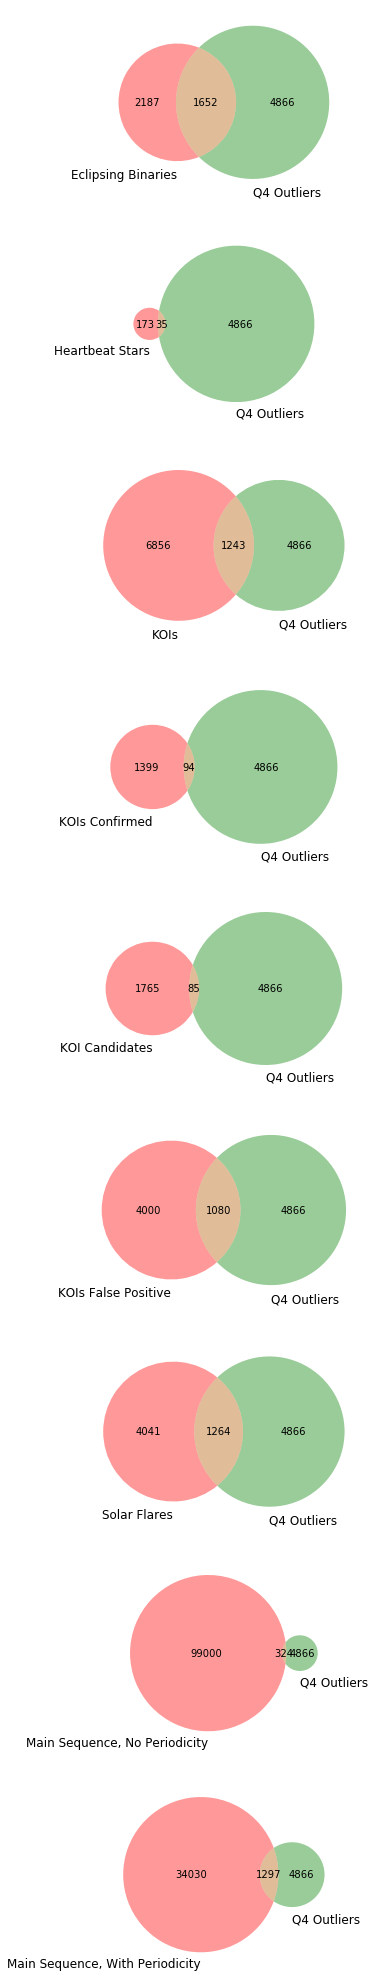

In [669]:
Q = 'Q4'
figure, axes = plt.subplots(len(summary_df.index), 1,figsize=(15,len(summary_df.index)*4))

for i in range(len(summary_df.index)):
    cat = i
    venn2(subsets = (summary_df.ctlg_ct[cat],len(outliers(paper_qs[Q].data)),summary_df['ctlg_U_'+Q+'out'][cat]),
          set_labels=(summary_df.index[cat],Q+' Outliers'),ax=axes[i])

In [753]:
score_df = base_qs['Q4'].data # dataframe containing scores
scores = lambda kics: score_df.loc[kics].dist_score

df = kois_full # dataframe of catalog
kic_list = [i[:13] for i in df.index] # KIC as kplr#########
kois_full_scores = scores(kic_list)

df = kois_confirmed
kic_list = [i[:13] for i in df.index]
kois_confirmed_scores = scores(kic_list)

df = kois_candidate
kic_list = [i[:13] for i in df.index]
kois_candidate_scores = scores(kic_list)

df = kois_fp
kic_list = [i[:13] for i in df.index]
kois_fp_scores = scores(kic_list)

df = ebs
kic_list = [i[:13] for i in df.index]
ebs_scores = scores(kic_list)

with open('list_kepler_heartbeats.txt','r') as file:
    lines = file.readlines()
kic_list = ['kplr'+'0'*(9-len(str(int(line[:8]))))+str(int(line[:8])) for line in lines[37:-2]]
heartbeat_scores = scores(kic_list).dropna()

with open('kepler_solar_flares.txt','r') as file:
    lines = file.readlines()
kic_list = ['kplr'+'0'*(9-len(str(int(line[:8]))))+str(int(line[:8])) for line in lines[22:]] 
flares_scores = scores(kic_list).dropna()

with open('list_kepler_nosig.txt','r') as file:
    lines = file.readlines()
kic_list = ['kplr'+'0'*(9-len(str(int(line[:8]))))+str(int(line[:8])) for line in lines[28:]] 
no_sig_scores = scores(kic_list).dropna()

with open('list_kepler_MSperiods.txt','r') as file:
    lines = file.readlines()
kic_list = ['kplr'+'0'*(9-len(str(int(line[:8]))))+str(int(line[:8])) for line in lines[32:]]  
periodic_scores = scores(kic_list).dropna()

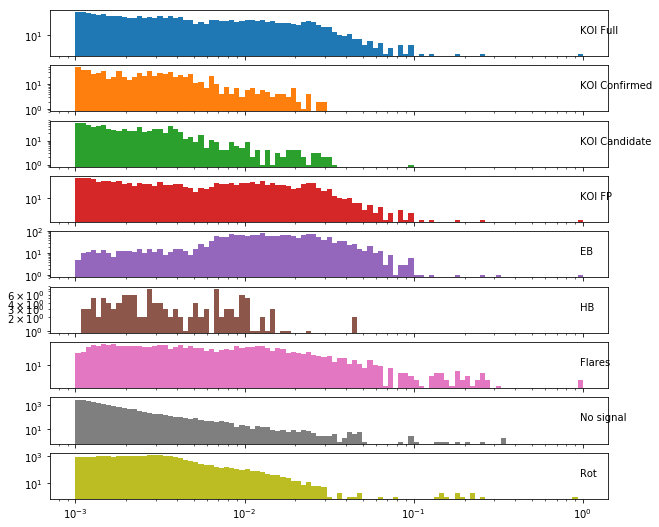

In [755]:
bins = np.logspace(-3,0,100)
plt.figure(figsize=(10,9))
i=0
ax = plt.subplot(9,1,i+1)
c= "C{}".format(i%10)
cl = 'KOI Full'
ax.hist(color=c,x=kois_full_scores,bins=bins,log=True)
ax.text(.95,0.5,"%s"%cl,transform=ax.transAxes)
ax.set_xscale('log')

i+=1
ax = plt.subplot(9,1,i+1)
c= "C{}".format(i%10)
cl = 'KOI Confirmed'
ax.hist(color=c,x=kois_confirmed_scores,bins=bins,log=True)
ax.text(.95,0.5,"%s"%cl,transform=ax.transAxes)
ax.set_xscale('log')

i+=1
ax = plt.subplot(9,1,i+1)
c= "C{}".format(i%10)
cl = 'KOI Candidate'
ax.hist(color=c,x=kois_candidate_scores,bins=bins,log=True)
ax.text(.95,0.5,"%s"%cl,transform=ax.transAxes)
ax.set_xscale('log')

i+=1
ax = plt.subplot(9,1,i+1)
c= "C{}".format(i%10)
cl = 'KOI FP'
ax.hist(color=c,x=kois_fp_scores,bins=bins,log=True)
ax.text(.95,0.5,"%s"%cl,transform=ax.transAxes)
ax.set_xscale('log')

i+=1
ax = plt.subplot(9,1,i+1)
c= "C{}".format(i%10)
cl = 'EB'
ax.hist(color=c,x=ebs_scores,bins=bins,log=True)
ax.text(.95,0.5,"%s"%cl,transform=ax.transAxes)
ax.set_xscale('log')

i+=1
ax = plt.subplot(9,1,i+1)
c= "C{}".format(i%10)
cl = 'HB'
ax.hist(color=c,x=heartbeat_scores,bins=bins,log=True)
ax.text(.95,0.5,"%s"%cl,transform=ax.transAxes)
ax.set_xscale('log')

i+=1
ax = plt.subplot(9,1,i+1)
c= "C{}".format(i%10)
cl = 'Flares'
ax.hist(color=c,x=flares_scores,bins=bins,log=True)
ax.text(.95,0.5,"%s"%cl,transform=ax.transAxes)
ax.set_xscale('log')

i+=1
ax = plt.subplot(9,1,i+1)
c= "C{}".format(i%10)
cl = 'No signal'
ax.hist(color=c,x=no_sig_scores,bins=bins,log=True)
ax.text(.95,0.5,"%s"%cl,transform=ax.transAxes)
ax.set_xscale('log')

i+=1
ax = plt.subplot(9,1,i+1)
c= "C{}".format(i%10)
cl = 'Rot'
ax.hist(color=c,x=periodic_scores,bins=bins,log=True)
ax.text(.95,0.5,"%s"%cl,transform=ax.transAxes)
ax.set_xscale('log')

In [ ]:
df = base_qs['Q4'].data
object_classes = summary_df.index

plt.figure(figsize=(10,len(object_classes)/2))
i=0
bins = np.logspace(-3,0,100)
for cl in object_classes:
    ax = plt.subplot(len(object_classes),1,i+1)
    c = "C{}".format(i%10)
    sampler = make_sampler[]
    ax.hist(df[df['Debosscher_class']==cl].dist_score,bins=bins,log=True,label=cl,color=c)
    ax.set_xscale('log')
    ax.text(.95,0.5,"%s"%cl,transform=ax.transAxes)
    i+=1

In [242]:
with open('kepler_variable_classes.txt','r') as file:
    lines = file.readlines()

In [249]:
tmp = np.genfromtxt('kepler_variable_classes.txt',dtype=str,skip_header=50)

In [269]:
tmp[tmp[:,4]=='SR'][:,0]

array(['7451258', '12216195', '4588755', '11129407'], 
      dtype='<U8')

In [267]:
for cl in np.unique(tmp[:,4]):
    print("{}: {}".format(cl,len(tmp[tmp[:,4]==cl])))

ACT: 20862
BCEP: 19187
CLCEP: 21
DSCUT: 1060
ECL: 2544
ELL: 200
GDOR: 488
MISC: 96745
ROT: 8654
RRAB: 6
RRC: 16
RVTAU: 3
SPB: 466
SR: 4


In [271]:
def catalog_summary(catalog_list,qs_dict):
    """
    Args:
        catalog_list (list) - a list of the KICs in the catalog as strings. May have KIC, kplr, or no prefix.
        qs_dict (dictionary) - a dictionary containing different quarters as clusterOutlier objects. 
                                qs_dict[key].data must be a pandas dataframe
    
    Returns:
        adict (dict) - a dictionary containing summary numbers for the catalog
            ctlg_ct - the size of the catalog
            ctlg_U_*out - size of the union between the catalog and the quarter's outliers 
    """
    outliers = lambda df: df[df.db_out==-1]

    adict = {"ctlg_ct":len(catalog_list)}
    catalog_sampler = make_sampler(catalog_list)
    for q in qs_dict:
        catalog_df = catalog_sampler(qs_dict[q].data)
        catalog_outliers = outliers(catalog_df)
        adict["ctlg_U_"+q+"out"]=len(catalog_outliers)
    return adictctlg_U_Q16out

Debosscher_summary = pd.DataFrame()

for cl in np.unique(tmp[:,4]):
    if cl != 'MISC':
        catalog_list = tmp[tmp[:,4]==cl][:,0]
        class_summary=catalog_summary(catalog_list,paper_qs)
        df_tmp = pd.DataFrame(class_summary,index=[cl])
        Debosscher_summary = Debosscher_summary.append(df_tmp)
    

In [382]:
# Run seperately because it contains 96,745 objects
cl='MISC'
catalog_list = tmp[tmp[:,4]==cl][:,0]
class_summary=catalog_summary(catalog_list,paper_qs)
df_tmp = pd.DataFrame(class_summary,index=[cl])
Debosscher_summary = Debosscher_summary.append(df_tmp)

In [383]:
Debosscher_summary

,ctlg_U_Q11out,ctlg_U_Q16out,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_ct
ACT,448,416,268,314,20862
BCEP,181,181,149,153,19187
CLCEP,18,17,18,18,21
DSCUT,150,160,108,104,1060
ECL,1136,1125,1081,1077,2544
ELL,126,118,116,116,200
GDOR,123,122,104,98,488
ROT,1413,1375,1153,1230,8654
RRAB,4,4,4,4,6
RRC,14,14,14,14,16


|Stellar variability class| 	Abbreviation| Count in Debosscher (in common w/ previous paper)*|
|-------------------------|-----------------|--------------------------------------------------|
|β-Cephei stars| 	BCEP| 19,187
|Classical Cepheids |	CLCEP| 21
|Double-mode Cepheids| 	DMCEP| 0
|δ-Scuti stars| 	DSCUT| 1060
|Eclipsing binaries (all types)| 	ECL| 2544
|Ellipsoidal variables| 	ELL| 200
|γ-Doradus stars| 	GDOR| 488
|Mira variables| 	MIRA| 0
|RR-Lyrae stars, subtype ab| 	RRAB| 6
|RR-Lyrae stars, subtype c| 	RRC| 16
|Double-mode RR-Lyrae stars| 	RRD| 0
|RV-Tauri stars| 	RVTAU| 3
|Slowly pulsating B-stars| 	SPB| 466
|Semi-regular variables| 	SR| 4
|Rotational modulation| 	ROT| 8654
|Active stars| 	ACT| 20862
|Miscellaneous| 	MISC| 96745

*Debosscher reports the probability for the top 3 classes for each object. The count here is based on primary identification without consideration of its probability of belonging to that group.

In [670]:
lines = np.genfromtxt('kepler_variable_classes.txt',dtype=str,skip_header=50)

In [674]:
Debosscher_full_df = pd.DataFrame(data=lines[:,4],columns=["Class"],index=[lines[:,0]])
Debosscher_full_df[:10]

,Class
2303694,MISC
3935492,MISC
7533643,ROT
3230719,MISC
6047853,MISC
9419545,MISC
4902107,MISC
8571870,MISC
11295149,MISC
4919193,MISC


In [697]:
df = base_qs['Q4'].data
obj_class = []
for i in df.index:
    if str(int(i[4:])) in Debosscher_full_df.index:
        obj_class.append(Debosscher_full_df.loc[str(int(i[4:]))].Class)
    else:
        obj_class.append('Undef')

In [701]:
base_qs['Q4'].data['Debosscher_class']=obj_class

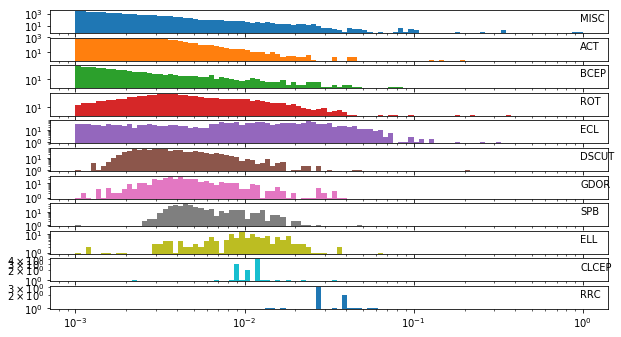

In [702]:
df = base_qs['Q4'].data
object_classes = Debosscher_summary[Debosscher_summary.ctlg_ct>10].sort_values('ctlg_ct',ascending=False).index

plt.figure(figsize=(10,len(object_classes)/2))
i=0
bins = np.logspace(-3,0,100)
for cl in object_classes:
    ax = plt.subplot(len(object_classes),1,i+1)
    c = "C{}".format(i%10)
    ax.hist(df[df['Debosscher_class']==cl].dist_score,bins=bins,log=True,label=cl,color=c)
    ax.set_xscale('log')
    ax.text(.95,0.5,"%s"%cl,transform=ax.transAxes)
    i+=1


### Simbad

In [ ]:
with open('simbad_bib.txt','r') as file:
    lines = file.readlines()

simbad_type_df = pd.DataFrame(columns=['Class'])
for line in lines:
    if line[:2] == 'KI':
        KIC = line[:-1]
    if line[:2] == 'Ob':
        string = line
        obj_type = string[string.index('---')+5:string.index('  ---  OID')]
        simbad_type_df = simbad_type_df.append(pd.DataFrame({'Class':obj_type},index=[KIC]))

In [319]:
out_paper = np.genfromtxt('outlier_properties.csv',delimiter=',',dtype=str)[:,0]

|Simbad code| 	Description|
|-------------------------|-----------------|
|*| Star (generic)|
|**| Double or multiple star|
|?| Object of unkonwn nature|
|Al*| Eclipsing binary of Algol type|
|BS*| Blue straggler star|
|BY*| Variable of BY Dra type|
|Be*| Be Star|
|C*| Carbon Star|
|CV*| Cataclysmic Variable Star|
|Ce*| Cepheid variable Star|
|DN*| Dwarf Nova|
|EB*| Eclipsing Binary|
|EB?| Eclipsing Binary Candidate|
|El*| Ellipsoidal variable Star|
|Em*| Emission-line Star|
|Er*| Eruptive variable Star|
|G| Galaxy|
|HS*| Hot subdwarf|
|LM*| Low-mass star (M<1M$_\odot$)|
|LP*| Long-period variable star|
|Mi*| Variable Star of Mira Cet type|
|No*| Nova|
|PM*| High proper-motion Star|
|Pe*| Peculiar Star|
|Pu*| Pulsating variable Star|
|RB?| Possible Red Giant Branch star|
|RG*| Red Giant Branch star|
|RR*| Variable Star of RR Lyr type|
|RS*| Variable of RS CVn type|
|RV*| Variable Star of RV Tau type|
|Ro*| Rotationally variable Star|
|S*| S Star|
|SB*| Spectroscopic binary|
|SX*| Variable Star of SX Phe type (subdwarf)|
|Sy1| Seyfert 1 Galaxy|
|V*| Variable Star|
|V*?| Star suspected of Variability|
|WU*| Eclipsing binary of W UMa type|
|a2*| Variable Star of alpha2 CVn type|
|bC*| Variable Star of beta Cep type|
|bL*| Eclipsing binary of beta Lyr type|
|cC*| Classical Cepheid (delta Cep type)|
|dS*| Variable Star of delta Sct type|
|gD*| Variable Star of gamma Dor type|

In [399]:
lines = np.genfromtxt('simbad.csv',delimiter=';',skip_header=7,dtype=str)[:,1:]

simbad_full_df = pd.DataFrame(data=lines[:,1],columns=["Class"],index=[lines[:,0]])

simbad_summary = pd.DataFrame()
for cl in simbad_full_df.Class.unique():
    if cl != '*':
        catalog_list = simbad_full_df[simbad_full_df.Class==cl].index
        class_summary=catalog_summary(catalog_list,paper_qs)
        df_tmp = pd.DataFrame(class_summary,index=[cl])
        simbad_summary = simbad_summary.append(df_tmp)


In [427]:
catalog_list = simbad_full_df[simbad_full_df.Class=='*'].index # ran seperately bc it contains >2/3 of the objects
class_summary=catalog_summary(catalog_list,paper_qs)
df_tmp = pd.DataFrame(class_summary,index=['*'])
simbad_summary = simbad_summary.append(df_tmp)
simbad_summary

,ctlg_U_Q11out,ctlg_U_Q16out,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_ct
Ce*,28,28,28,28,29
Er*,170,187,122,128,1112
Ro*,1885,1788,1450,1553,26223
Al*,737,737,732,724,794
RG*,38,41,28,32,3249
EB*,560,551,511,507,1004
PM*,51,46,18,33,1319
V*,60,58,54,58,264
dS*,91,93,76,71,463
Pu*,76,77,61,68,147


In [456]:
simbad_summary[simbad_summary.ctlg_ct>100].sort_values('ctlg_ct',ascending=False)

,ctlg_U_Q11out,ctlg_U_Q16out,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_ct
*,879,883,627,685,94309
Ro*,1885,1788,1450,1553,26223
RG*,38,41,28,32,3249
PM*,51,46,18,33,1319
Er*,170,187,122,128,1112
EB*,560,551,511,507,1004
Al*,737,737,732,724,794
dS*,91,93,76,71,463
WU*,407,405,401,396,416
V*,60,58,54,58,264


In [479]:
simbad_classes = simbad_sampler(simbad_full_df)

In [508]:
df = base_qs['Q4'].data
obj_class = []
for i in df.index:
    if i in simbad_full_df.index:
        obj_class.append(simbad_full_df.loc[i].Class)
    else:
        obj_class.append('Undef')

In [516]:
base_qs['Q4'].data['simbad_class'] = obj_class

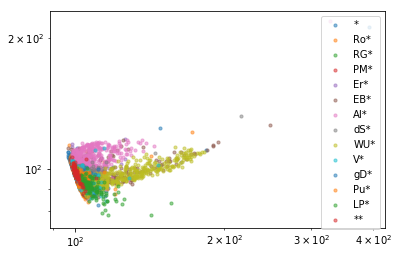

In [563]:
for cl in simbad_summary[simbad_summary.ctlg_ct>100].sort_values('ctlg_ct',ascending=False).index:
    plt.scatter(df[df['simbad_class']==cl].pca_x+100,df[df['simbad_class']==cl].pca_y+100,s=10,alpha=0.5,label=cl)

#plt.scatter(df[df['simbad_class']=='Undef'].pca_x,df[df['simbad_class']=='Undef'].pca_y,s=2,alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [634]:
featCSV = "/home/dgiles/Documents/KeplerLCs/output/paper_sample_4" # Path to csv containing feature data (should be a pandas dataframe saved as a csv)
fitsDir = "/home/dgiles/Documents/KeplerLCs/fitsFiles/Q4fitsfiles" # path to fits files
Q4_sample = coo(featCSV,fitsDir)

tsne_sample_list = [i[4:13] for i in Q4_sample.data.index]
tsneSampler = make_sampler(tsne_sample_list)
Q4_tsneSampleClasses = tsneSampler(base_qs['Q4'].data).simbad_class

Q4_sample.data['simbad_class']=Q4_tsneSampleClasses.as_matrix()

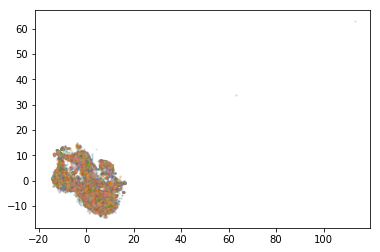

In [640]:
df = Q4_sample.data
for cl in simbad_summary[simbad_summary.ctlg_ct>100].sort_values('ctlg_ct',ascending=False).index:
    plt.scatter(df[df['simbad_class']==cl].tsne_x,df[df['simbad_class']==cl].tsne_y,s=2,alpha=0.2,label=cl)

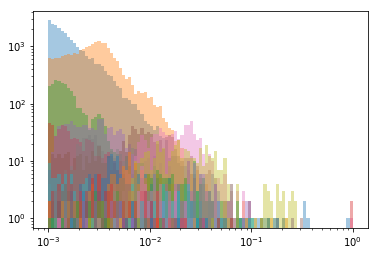

In [543]:
df = base_qs['Q4'].data
bins = np.logspace(-3,0,100)
for cl in simbad_summary.sort_values('ctlg_ct',ascending=False).index:
    plt.hist(df[df['simbad_class']==cl].dist_score,bins=bins,log=True,alpha=0.4,label=cl)
    
plt.xscale('log')
#plt.legend()

/home/dgiles/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  --------


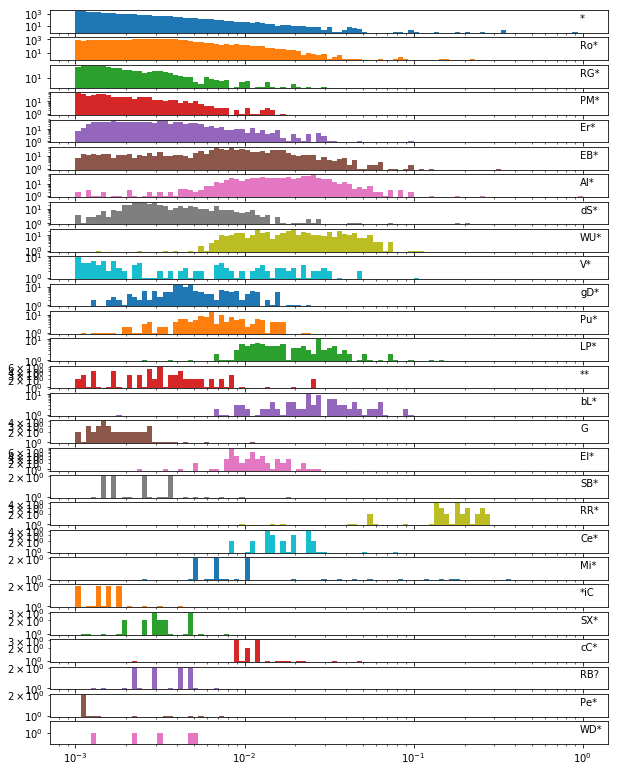

In [645]:
df = base_qs['Q4'].data
object_classes = simbad_summary[simbad_summary.ctlg_ct>10].sort_values('ctlg_ct',ascending=False).index

plt.figure(figsize=(10,len(object_classes)/2))
i=0
bins = np.logspace(-3,0,100)
for cl in object_classes:
    ax = plt.subplot(len(object_classes),1,i+1)
    c = "C{}".format(i%10)
    ax.hist(df[df['simbad_class']==cl].dist_score,bins=bins,log=True,label=cl,color=c)
    ax.set_xscale('log')
    ax.text(.95,0.5,"%s"%cl,transform=ax.transAxes)
    i+=1


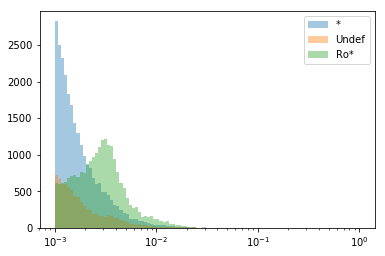

In [542]:
df = base_qs['Q4'].data
bins = np.logspace(-3,0,100)
plt.hist(df[df['simbad_class']=='*'].dist_score,bins=bins,log=False,alpha=0.4,label='*')
plt.hist(df[df['simbad_class']=='Undef'].dist_score,bins=bins,log=False,alpha=0.4,label='Undef')
plt.hist(df[df['simbad_class']=='Ro*'].dist_score,bins=bins,log=False,alpha=0.4,label='Ro*')

plt.xscale('log')
plt.legend()

In [470]:
simbad_sampler = make_sampler(simbad_full_df.index)
simbad_sample = simbad_sampler(base_qs['Q4'].data)

In [484]:
simbad_summary

,ctlg_U_Q11out,ctlg_U_Q16out,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_ct
Ce*,28,28,28,28,29
Er*,170,187,122,128,1112
Ro*,1885,1788,1450,1553,26223
Al*,737,737,732,724,794
RG*,38,41,28,32,3249
EB*,560,551,511,507,1004
PM*,51,46,18,33,1319
V*,60,58,54,58,264
dS*,91,93,76,71,463
Pu*,76,77,61,68,147


In [485]:
tmp_df = pd.DataFrame({'Mean':[simbad_sample[simbad_classes.Class==c].dist_score.mean() for c in simbad_classes.Class.unique()],
                       'Median':[simbad_sample[simbad_classes.Class==c].dist_score.median() for c in simbad_classes.Class.unique()]
                      },index=simbad_classes.Class.unique())

In [ ]:

for c in simbad_classes.Class.unique():

    subset = simbad_sample[simbad_classes.Class==c]
    mean = subset.dist_score.mean()
    med = subset.dist_score.median()
    simbad
    print("""
Class {}: Number of objects: {}, Mean outlier score: {}, Median outlier score: {}
""".format(c,len(subset),mean,med))

In [489]:
simbad_classes.Q4_mean = tmp_df.Mean

In [492]:
simbad_summary.Q4_mean = tmp_df.Mean

In [498]:
simbad_summary['Q4_median'] = tmp_df.Median

In [756]:
simbad_summary

,ctlg_U_Q11out,ctlg_U_Q16out,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_ct,Q4_mean,Q4_median
Ce*,28,28,28,28,29,0.020462,0.016599
Er*,170,187,122,128,1112,0.004166,0.002820
Ro*,1885,1788,1450,1553,26223,0.002968,0.002387
Al*,737,737,732,724,794,0.021043,0.016808
RG*,38,41,28,32,3249,0.001695,0.001344
EB*,560,551,511,507,1004,0.009881,0.006867
PM*,51,46,18,33,1319,0.001440,0.000892
V*,60,58,54,58,264,0.005073,0.001027
dS*,91,93,76,71,463,0.005744,0.003058
Pu*,76,77,61,68,147,0.007226,0.006300


We want to be able to plug in an individual object and retreive information on it including:
* it's scores
  * score for each quarter
  * rank for each quarter
  * score/rank in relation to similar objects (if previously classified)
* any previous classifications
* it's lightcurve

In [954]:
#import quarterTools as qt
catalogs = {'koi_full':['list_koi_full.txt',',',2],
            'koi_confirmed':['list_koi_confirmed.txt',',',2],
            'koi_candidate':['list_koi_candidate.txt',',',2],
            'koi_fp':['list_koi_fp.txt',',',2],
            'EB':['list_EBs.csv',',',0],
            'HB':['list_kepler_heartbeats.txt',None,37],
            'flares':['kepler_solar_flares.txt',None,22],
            'no_signal':['list_kepler_nosig.txt',None,28],
            'periodic':['list_kepler_MSperiods.txt',None,32]}

class weirdnessProfile(object):
    def __init__(self,
                 KIC='8462852',
                 Qs=['Q4','Q8','Q11','Q16'],
                 analysis_path='/home/dgiles/Documents/KeplerLCs/output/Analysis/',
                 fitsDirPath='/home/dgiles/Documents/KeplerLCs/fitsFiles/'):
        if KIC[:3]=='KIC':
            self.KIC = str(int(KIC[3:]))
        elif KIC[:4]=='kplr':
            self.KIC = str(int(KIC[4:]))
        else:
            try:
                self.KIC = str(int(KIC))
            except:
                print("ID not recognized. Try without a prefix?")
        self.Qs = Qs
        self.analysis_path = analysis_path
        self.fitsDirPath = fitsDirPath
        self.sampler = lambda df: df[df.index.str.contains(self.KIC)]
        self.full_analysis_data = {Q:pd.read_csv(self.analysis_path+Q+'_analysis.csv',index_col=0) for Q in self.Qs}
        self.analysis_data = {Q:self.sampler(self.full_analysis_data[Q]) for Q in self.Qs}
        self.scores = self.scoreSummary()
        self.ranks = self.rankSummary()
        self.catalogs,self.ctlg_sampler = self.catalogCheck()
        
    def scoreSummary(self):
        scores = pd.DataFrame()
        for Q in self.Qs:
            dftmp = analysis_data[Q].loc[:,['dist_score','PCA90_score','PCA95_score','PCA99_score']]
            dftmp.index = [Q]
            scores = scores.append(dftmp)
        return scores
    
    def rankSummary(self):
        full_ranks={}
        for Q in self.Qs:
            full_ranks[Q] = self.full_analysis_data[Q].loc[:,[]]
            full_ranks[Q]['Full'] = self.full_analysis_data[Q].dist_score.rank(ascending=False)/len(self.full_analysis_data[Q])*100
            full_ranks[Q]['PCA90'] = self.full_analysis_data[Q].PCA90_score.rank(ascending=False)/len(self.full_analysis_data[Q])*100
            full_ranks[Q]['PCA95'] = self.full_analysis_data[Q].PCA95_score.rank(ascending=False)/len(self.full_analysis_data[Q])*100
            full_ranks[Q]['PCA99'] = self.full_analysis_data[Q].PCA99_score.rank(ascending=False)/len(self.full_analysis_data[Q])*100
        self.full_ranks = full_ranks
        
        ranks = pd.DataFrame()
        for Q in self.Qs:
            dftmp = self.sampler(full_ranks[Q])
            dftmp.index = [Q]
            ranks = ranks.append(dftmp)
        return ranks
    
    def plotlcs(self):
        for Q in self.Qs:
            qt.plot_lc(self.analysis_data[Q].index[0],self.fitsDirPath+Q+'fitsfiles/')
        return
    
    def pcaPlots(self):
        for Q in self.Qs:
            x = self.full_analysis_data[Q].pca_x
            y = self.full_analysis_data[Q].pca_y
            fig = plt.figure(figsize=(4,4))
            ax = fig.add_subplot(111)
            ax.scatter(x,y)
            ax.scatter(self.analysis_data[Q].pca_x,self.analysis_data[Q].pca_y)
            
    def catalogCheck(self):
        in_catalogs = []
        ctlg_sampler = {}
        for ctlg in catalogs:
            import_ref = catalogs[ctlg]
            ctlg_list = np.genfromtxt(import_ref[0],delimiter=import_ref[1],skip_header=import_ref[2],usecols=(0),dtype=str)
            if self.KIC in ctlg_list:
                in_catalogs.append(ctlg)
                ctlg_sampler[ctlg] = make_sampler(ctlg_list)
        if self.KIC in Debosscher_full_df.index:
            deb_class = Debosscher_full_df.loc[self.KIC,'Class']
            ctlg_sampler['Debosscher Class %s'%deb_class]=make_sampler(Debosscher_full_df[Debosscher_full_df.Class==deb_class].index)
            in_catalogs.append('Debosscher Class %s'%deb_class)
        if self.KIC in simbad_full_df.index:
            sim_class = simbad_full_df.loc[self.KIC,'Class']
            ctlg_sampler['SIMBAD Class %s'%sim_class]=make_sampler(simbad_full_df[simbad_full_df.Class == sim_class].index)
            in_catalogs.append('SIMBAD Class %s'%sim_class)
            
        return in_catalogs,ctlg_sampler
    
    def catalogCompare(self):
        catalog_data_summary = {}
        for ctlg in self.catalogs:
            catalog_data_summary[ctlg] = pd.DataFrame()
            for Q in Qs:
                ctlg_data = self.ctlg_sampler[ctlg](self.full_analysis_data[Q])
                tmp_df = pd.DataFrame({'dist_score':ctlg_data.dist_score.mean(),
                                       'PCA90_score':ctlg_data.PCA90_score.mean(),
                                       'PCA95_score':ctlg_data.PCA95_score.mean(),
                                       'PCA99_score':ctlg_data.PCA99_score.mean()},
                                      index=[Q])
                catalog_data_summary[ctlg].append(tmp_df)
        self.ctlg_summary = catalog_data_summary
        return catalog_data_summary

In [955]:
tabby = weirdnessProfile('8462852')
tabby.catalogCheck()

(['Debosscher Class ACT'],
 {'Debosscher Class ACT': <function __main__.make_sampler.<locals>.<lambda>>})

In [956]:
tabby.catalogCompare()

{'Debosscher Class ACT': Empty DataFrame
 Columns: []
 Index: []}

In [959]:
in_catalogs = []
ctlg_sampler = {}
if '8462852' in Debosscher_full_df.index:
    deb_class = Debosscher_full_df.loc['8462852','Class']
    ctlg_sampler['Debosscher Class %s'%deb_class]=make_sampler(Debosscher_full_df[Debosscher_full_df.Class==deb_class].index)
    in_catalogs.append('Debosscher Class %s'%deb_class)


In [962]:
ctlg_sampler['Debosscher Class ACT'](tabby.full_analysis_data['Q4'])

,pca_x,pca_y,db_out,dist_score,PCA90_score,PCA95_score,PCA99_score
kplr000891916-2010078095331_llc.fits,1.590050,-4.515781,0,0.003161,0.002746,0.003806,0.005731
kplr001026309-2010078095331_llc.fits,1.217921,-4.351079,0,0.003001,0.002926,0.004070,0.005854
kplr001026838-2010078095331_llc.fits,-0.089931,-1.343676,0,0.001019,0.001028,0.001255,0.001732
kplr001026895-2010078095331_llc.fits,2.381934,-5.270267,0,0.005920,0.004845,0.007322,0.011482
kplr001027110-2010078095331_llc.fits,1.534613,-5.000489,0,0.003617,0.002659,0.004735,0.007359
kplr001027707-2010078095331_llc.fits,1.501253,-5.602406,0,0.003567,0.003046,0.004281,0.006456
kplr001027740-2010078095331_llc.fits,1.698807,-7.121197,0,0.002951,0.002249,0.003269,0.006023
kplr001160789-2010078095331_llc.fits,1.605899,-4.680848,0,0.002417,0.002324,0.002853,0.003602
kplr001161491-2010078095331_llc.fits,-0.288918,-0.437789,0,0.001375,0.001498,0.001744,0.002216
kplr001162220-2010078095331_llc.fits,1.533775,-4.832301,0,0.003042,0.003227,0.004017,0.006542


In [ ]:
summary_df.to_csv()

In [963]:
for ctlg in catalogs:
    import_ref = catalogs[ctlg]
    ctlg_list = np.genfromtxt(import_ref[0],delimiter=import_ref[1],skip_header=import_ref[2],usecols=(0),dtype=str)
    ctlg_sampler[ctlg] = make_sampler(ctlg_list)
    for Q in Qs:
        ctlg_analysis_data = ctlg_sampler[ctlg](tabby.full_analysis_data[Q])
        ctlg_analysis_data.to_csv('/home/dgiles/Documents/KeplerLCs/output/Analysis/'+Q+'_'+ctlg+'_analysis.csv')

In [968]:
for Q in Qs:
    ctlg_analysis_data = ctlg_sampler[ctlg](tabby.full_analysis_data[Q])
    ctlg_analysis_data.to_csv('/home/dgiles/Documents/KeplerLCs/output/Analysis/'+Q+'_'+ctlg+'_analysis.csv')

In [969]:
for cl in Debosscher_full_df.Class.unique():
    ctlg = 'Deb_Class_%s'%cl
    ctlg_sampler[ctlg]=make_sampler(Debosscher_full_df[Debosscher_full_df.Class == cl].index)
    print("Debosscher Class %s"%cl)
    for Q in Qs:
        print("Quarter %s"%Q)
        ctlg_analysis_data = ctlg_sampler[ctlg](tabby.full_analysis_data[Q])
        ctlg_analysis_data.to_csv('/home/dgiles/Documents/KeplerLCs/output/Analysis/'+Q+'_'+ctlg+'_analysis.csv')

for cl in simbad_full_df.Class.unique():
    ctlg = 'SIMBAD_Class_%s'%cl
    ctlg_sampler[ctlg]=make_sampler(simbad_full_df[simbad_full_df.Class == cl].index)
    print("Simbad Class %s"%cl)
    for Q in Qs:
        print("Quarter %s"%Q)
        ctlg_analysis_data = ctlg_sampler[ctlg](tabby.full_analysis_data[Q])
        ctlg_analysis_data.to_csv('/home/dgiles/Documents/KeplerLCs/output/Analysis/'+Q+'_'+ctlg+'_analysis.csv')

Debosscher Class MISC
Quarter Q4
Quarter Q8
Quarter Q11
Quarter Q16
Debosscher Class ROT
Quarter Q4
Quarter Q8
Quarter Q11
Quarter Q16
Debosscher Class BCEP
Quarter Q4
Quarter Q8
Quarter Q11
Quarter Q16
Debosscher Class ACT
Quarter Q4
Quarter Q8
Quarter Q11
Quarter Q16
Debosscher Class ECL
Quarter Q4
Quarter Q8
Quarter Q11
Quarter Q16
Debosscher Class DSCUT
Quarter Q4
Quarter Q8
Quarter Q11
Quarter Q16
Debosscher Class GDOR
Quarter Q4
Quarter Q8
Quarter Q11
Quarter Q16
Debosscher Class ELL
Quarter Q4
Quarter Q8
Quarter Q11
Quarter Q16
Debosscher Class SPB
Quarter Q4
Quarter Q8
Quarter Q11
Quarter Q16
Debosscher Class CLCEP
Quarter Q4
Quarter Q8
Quarter Q11
Quarter Q16
Debosscher Class RRAB
Quarter Q4
Quarter Q8
Quarter Q11
Quarter Q16
Debosscher Class RVTAU
Quarter Q4
Quarter Q8
Quarter Q11
Quarter Q16
Debosscher Class RRC
Quarter Q4
Quarter Q8
Quarter Q11
Quarter Q16
Debosscher Class SR
Quarter Q4
Quarter Q8
Quarter Q11
Quarter Q16
Simbad Class *
Quarter Q4
Quarter Q8
Quarter Q11
Quar

Catalogs import information

|Catalog|Delimiter|Header Length|
|-------|---------|-------------|
|list_koi_full.txt|','|2|
|list_koi_confirmed.txt|','|2|
|list_koi_candidate.txt|','|2|
|list_koi_fp.txt|','|2|
|list_EBs.csv|','|0|
|list_kepler_heartbeats.txt|None|37|
|kepler_solar_flares.txt|None|22|
|list_kepler_nosig.txt|None|28|
|list_kepler_MSperiods.txt|None|32|



In [800]:
catalogs = {'koi_full':['list_koi_full.txt',',',2],
            'koi_confirmed':['list_koi_confirmed.txt',',',2],
            'koi_candidate':['list_koi_candidate.txt',',',2],
            'koi_fp':['list_koi_fp.txt',',',2],
            'EB':['list_EBs.csv',',',0],
            'HB':['list_kepler_heartbeats.txt',None,37],
            'flares':['kepler_solar_flares.txt',None,22],
            'no_signal':['list_kepler_nosig.txt',None,28],
            'periodic':['list_kepler_MSperiods.txt',None,32]}